In [1]:
# ---- 1) imports + where the files live ----
from pathlib import Path
import re, numpy as np, pandas as pd

# EITHER: point directly to the folder that has the PKLs
DATA_DIR = Path.cwd()  # <- change this to your folder if needed

# OR automatically search from current workspace:
def find_file(name: str, start: Path) -> Path:
    hits = list(start.rglob(name))
    if not hits:
        raise FileNotFoundError(f"Could not find {name!r} under {start}")
    if len(hits) > 1:
        print(f"[warn] multiple matches for {name!r}, using first:\n  " + "\n  ".join(map(str, hits[:3])))
    return hits[0]

gamma_path = (DATA_DIR / "gamma_dataset_1to120GeVScndEHCAL.pkl")
pion_path  = (DATA_DIR / "pion_dataset_1to120GeVScndEHCAL.pkl")
if not gamma_path.exists(): gamma_path = find_file("gamma_dataset_1to120GeVScndEHCAL.pkl", Path.cwd())
if not pion_path.exists():  pion_path  = find_file("pion_dataset_1to120GeVScndEHCAL.pkl",  Path.cwd())

print("Loading:")
print("  ", gamma_path)
print("  ", pion_path)

# ---- 2) load dataframes ----
df_gamma = pd.read_pickle(gamma_path)
df_pion  = pd.read_pickle(pion_path)

# ---- 3) helpers ----
def ensure_sensor_energy(df: pd.DataFrame) -> pd.DataFrame:
    # keep if present and non-empty
    if "sensor_energy" in df.columns and len(df) and df["sensor_energy"].apply(
        lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0
    ).all():
        return df
    # else build from layer_###_MeV columns
    layer_cols = sorted(
        [c for c in df.columns if re.fullmatch(r"layer_\d{3}_MeV", c)],
        key=lambda s: int(s.split("_")[1])
    )
    if not layer_cols:
        raise RuntimeError("No per-layer info: neither non-empty 'sensor_energy' nor 'layer_XXX_MeV' columns.")
    out = df.copy()
    out["sensor_energy"] = out[layer_cols].values.tolist()
    return out

def peek_df(df: pd.DataFrame, name="df"):
    print(f"\n{name}: rows={len(df)}  cols={len(df.columns)}")
    print("has 'sensor_energy'?", "sensor_energy" in df.columns)
    if len(df) and "true_energy" in df.columns:
        print("true_energy  min/mean/max:",
              float(df["true_energy"].min()),
              float(df["true_energy"].mean()),
              float(df["true_energy"].max()))
    if len(df) and "sensor_energy" in df.columns:
        ok = df["sensor_energy"].apply(lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0)
        print("non-empty sensor_energy rows:", int(ok.sum()), "/", len(df))
        if ok.any():
            first = np.asarray(df.loc[ok.idxmax(),"sensor_energy"], float)
            print("example layers:", first.size)

# ---- 4) inspect raw ----
peek_df(df_gamma, "gamma_train (raw)")
peek_df(df_pion,  "pion_train  (raw)")

# ---- 5) ensure sensor_energy present ----
df_gamma = ensure_sensor_energy(df_gamma)
df_pion  = ensure_sensor_energy(df_pion)

# ---- 6) inspect fixed + combined ----
peek_df(df_gamma, "gamma_train (fixed)")
peek_df(df_pion,  "pion_train  (fixed)")

df_train = pd.concat([df_gamma, df_pion], ignore_index=True)
peek_df(df_train, "df_train (fixed, combined)")


Loading:
   /Users/egeeroglu/Desktop/Notebooks/SimulationData/gamma_dataset_1to120GeVScndEHCAL.pkl
   /Users/egeeroglu/Desktop/Notebooks/SimulationData/pion_dataset_1to120GeVScndEHCAL.pkl

gamma_train (raw): rows=5000  cols=14
has 'sensor_energy'? True
true_energy  min/mean/max: 1.0640508933276285 60.69317554624265 119.98491771978009
non-empty sensor_energy rows: 5000 / 5000
example layers: 156

pion_train  (raw): rows=5000  cols=14
has 'sensor_energy'? True
true_energy  min/mean/max: 1.0205562471203025 60.78416554997382 119.99811400251663
non-empty sensor_energy rows: 5000 / 5000
example layers: 156

gamma_train (fixed): rows=5000  cols=14
has 'sensor_energy'? True
true_energy  min/mean/max: 1.0640508933276285 60.69317554624265 119.98491771978009
non-empty sensor_energy rows: 5000 / 5000
example layers: 156

pion_train  (fixed): rows=5000  cols=14
has 'sensor_energy'? True
true_energy  min/mean/max: 1.0205562471203025 60.78416554997382 119.99811400251663
non-empty sensor_energy rows: 

In [5]:
# --- 0) Imports ---
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# (Optional) W&B — safe to skip if not installed or you don't want logging
try:
    import wandb
    WANDB_OK = True
except Exception:
    WANDB_OK = False

# ---------- 1) Expect df_gamma / df_pion already loaded ----------
# They must contain:
#   - 'sensor_energy': array-like of length 156 per row
#   - 'true_energy'  : scalar (GeV)
# From your earlier prints, both are present and valid.

import pandas as pd

def df_to_arrays(df: pd.DataFrame):
    X = np.stack(df["sensor_energy"].to_numpy()).astype("float32")  # (N, 156)
    y = df["true_energy"].to_numpy().astype("float32").reshape(-1, 1)  # (N, 1)
    return X, y

Xg, yg = df_gamma.pipe(df_to_arrays)
Xp, yp = df_pion.pipe(df_to_arrays)

# Combine & shuffle
X = np.concatenate([Xg, Xp], axis=0)
y = np.concatenate([yg, yp], axis=0)

perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# ---------- 2) Train/val split + standardization ----------
N = len(X)
val_frac = 0.2
n_val = int(N * val_frac)
n_train = N - n_val

X_train, X_val = X[:n_train], X[n_train:]
y_train, y_val = y[:n_train], y[n_train:]

# Standardize features using TRAIN stats only
x_mean = X_train.mean(axis=0, keepdims=True)
x_std  = X_train.std(axis=0, keepdims=True)
x_std  = np.where(x_std < 1e-6, 1.0, x_std)  # guard against div-by-zero

X_train = (X_train - x_mean) / x_std
X_val   = (X_val   - x_mean) / x_std

# Torch tensors
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_val_t   = torch.from_numpy(X_val).to(device)
y_val_t   = torch.from_numpy(y_val).to(device)

# DataLoaders
batch_size = 32
tr_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
va_loader = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False)

# ---------- 3) Model / Optim / Loss ----------
input_dim = X_train.shape[1]  # should be 156

model = nn.Sequential(
    nn.Linear(input_dim, 256), nn.GELU(),
    nn.Linear(256, 128), nn.GELU(),
    nn.Linear(128, 1), nn.Softplus()   # keeps predictions positive
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

def relE_loss(pred, y):
    # ((E_true - E_pred)^2)/E_true, with a tiny floor for safety
    y_safe = torch.clamp(y, min=1e-6)
    return torch.mean(((y - pred)**2) / y_safe)

# ---------- 4) W&B setup (optional) ----------
wb = None
if WANDB_OK:
    try:
        wandb.login()  # no-op if already logged in
        wb = wandb.init(
            project="calo-dnn",
            name="500epoch_run",
            config={
                "architecture": "256-128-1 Softplus",
                "activation": "GELU",
                "optimizer": "AdamW",
                "lr": 1e-3,
                "weight_decay": 1e-5,
                "epochs": 500,
                "batch_size": batch_size,
                "loss": "((E_true - E_pred)^2)/E_true",
                "input_dim": int(input_dim),
                "val_frac": float(val_frac),
            },
        )
    except Exception as e:
        print("W&B init skipped:", e)
        wb = None

# ---------- 5) Train ----------
epochs = 500
best_val = float("inf")
patience, bad = 30, 0  # early stop (tweak or remove)

for epoch in range(1, epochs + 1):
    # train
    model.train()
    total = 0.0
    for xb, yb in tr_loader:
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = relE_loss(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    train_loss = total / n_train

    # validate
    model.eval()
    val_total = 0.0
    with torch.no_grad():
        for xb, yb in va_loader:
            val_total += relE_loss(model(xb), yb).item() * xb.size(0)
    val_loss = val_total / n_val

    # log
    if wb is not None:
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
                   "lr": opt.param_groups[0]["lr"]})

    # simple early stopping
    if val_loss + 1e-6 < best_val:
        best_val = val_loss
        bad = 0
        torch.save({
            "model": model.state_dict(),
            "x_mean": x_mean,
            "x_std": x_std,
        }, "calo_dnn_best.pt")
    else:
        bad += 1
        if bad >= patience:
            print(f"Early stop at epoch {epoch} (best val={best_val:.6f})")
            break

print(f"✅ Done. Best val loss: {best_val:.6f}")
if wb is not None:
    wandb.finish()

# ---------- 6) Quick sanity check ----------
model.eval()
with torch.no_grad():
    pred_val = model(X_val_t[:8])
print("True (GeV):", y_val[:8, 0])
print("Pred (GeV):", pred_val.squeeze().cpu().numpy())


Early stop at epoch 105 (best val=0.197568)
✅ Done. Best val loss: 0.197568


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
val_loss,█▄▃▂▂▃▁▁▂▂▁▂▂▂▂▁▁▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁
epoch,105
lr,0.001
train_loss,0.08472
val_loss,0.22567


True (GeV): [ 90.14674     4.4466696 112.46174   103.357704   20.749441   60.67395
  95.58351    80.044106 ]
Pred (GeV): [ 90.66798     1.9250867 114.77998   104.28916    19.680252   60.26628
  94.55828    78.928246 ]


gamma: /Users/egeeroglu/Desktop/Notebooks/eval_gamma_1to100ScndEHCAL.pkl
pion : /Users/egeeroglu/Desktop/Notebooks/eval_pion_1to100ScndEHCAL.pkl
eval rows: 2000

--- Eval metrics ---
DNN loss=0.240 | BASE loss=40.733 | MAE=1.595 GeV | RMSE=3.366 GeV


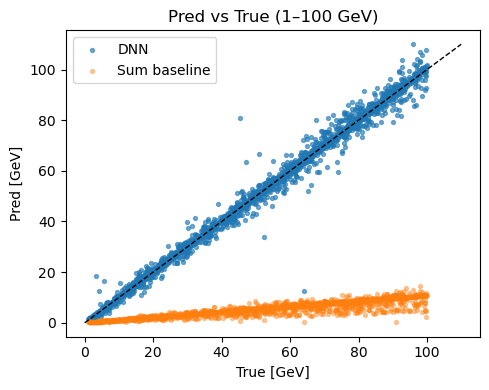

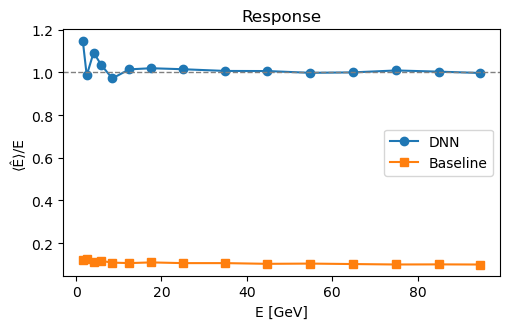

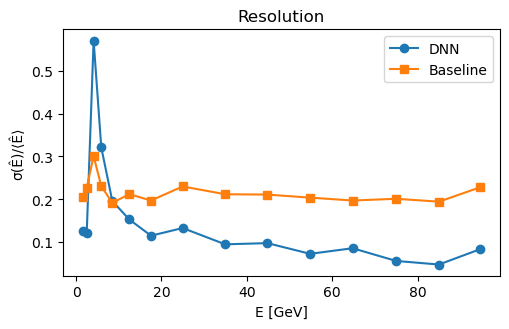

In [8]:
# ==== Eval on eval_gamma_1to100ScndEHCAL + eval_pion_1to100ScndEHCAL ====
import os, re
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from torch import nn

# ---------- tiny utils ----------
def find_one(stem, root=Path.cwd()):
    """Find first file matching given base name for common extensions."""
    pats = [f"{stem}.pkl", f"{stem}.parquet", f"{stem}.csv",
            f"*{stem}*.pkl", f"*{stem}*.parquet", f"*{stem}*.csv"]
    for pat in pats:
        hits = sorted(root.rglob(pat))
        if hits:
            return hits[0]
    return None

def smart_read(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf == ".pkl":
        return pd.read_pickle(path)
    if suf == ".parquet":
        return pd.read_parquet(path)
    if suf == ".csv":
        return pd.read_csv(path)
    raise ValueError(f"Unsupported file type: {path}")

def ensure_sensor_energy(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure df['sensor_energy'] exists; else build from layer_XXX_MeV columns."""
    if "sensor_energy" in df.columns and df["sensor_energy"].apply(
        lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0
    ).all():
        return df
    layer_cols = sorted(
        [c for c in df.columns if re.fullmatch(r"layer_\d{3}_MeV", c)],
        key=lambda s: int(s.split("_")[1])
    )
    if not layer_cols:
        raise RuntimeError("No per-layer info: neither 'sensor_energy' nor 'layer_XXX_MeV' columns.")
    out = df.copy()
    out["sensor_energy"] = out[layer_cols].values.tolist()
    return out

def to_matrix(sensor_energy_col, max_layers: int) -> np.ndarray:
    rows = [np.asarray(v, np.float32).ravel() for v in sensor_energy_col]
    M = np.zeros((len(rows), int(max_layers)), np.float32)
    for i,a in enumerate(rows):
        k = min(M.shape[1], a.size)
        if k:
            M[i,:k] = a[:k]
    return M

# ---------- 1) Load eval files ----------
gamma_path = find_one("eval_gamma_1to100ScndEHCAL")
pion_path  = find_one("eval_pion_1to100ScndEHCAL")
print("gamma:", gamma_path)
print("pion :", pion_path)
assert gamma_path is not None and pion_path is not None, "Could not find eval files."

df_eval = pd.concat([smart_read(gamma_path), smart_read(pion_path)], ignore_index=True)
df_eval = ensure_sensor_energy(df_eval)
# restrict to 1–100 GeV (your training range)
df_eval = df_eval[(df_eval["true_energy"] >= 1.0) & (df_eval["true_energy"] <= 100.0)].reset_index(drop=True)
print(f"eval rows: {len(df_eval)}")

# ---------- 2) Load checkpoint + rebuild model ----------
ckpt_path = Path("calo_dnn_best.pt")
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path.resolve()}"

# PyTorch 2.6+ default weights_only=True blocks numpy objects; use weights_only=False for this trusted file
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
x_mean = ckpt["x_mean"].astype(np.float32)  # shape (1, D)
x_std  = ckpt["x_std"].astype(np.float32)   # shape (1, D)
D = int(x_mean.shape[1])

# Recreate the exact architecture you trained (256→128→1, GELU, Softplus output)
model = nn.Sequential(
    nn.Linear(D, 256), nn.GELU(),
    nn.Linear(256, 128), nn.GELU(),
    nn.Linear(128, 1), nn.Softplus()
).eval()
model.load_state_dict(ckpt["model"])

# ---------- 3) Build features, normalize with TRAIN scalers ----------
M = to_matrix(df_eval["sensor_energy"], max_layers=D)
X = (M - x_mean) / (x_std + 1e-12)

# ---------- 4) Predict ----------
with torch.no_grad():
    y_pred = model(torch.tensor(X, dtype=torch.float32)).numpy().ravel()
y_true = df_eval["true_energy"].to_numpy(float)

# Simple sum baseline (GeV)
y_base = M.sum(axis=1) / 1000.0

# ---------- 5) Metrics ----------
dnn_loss  = float(np.mean(((y_true - y_pred)**2) / np.clip(y_true, 1e-12, None)))
base_loss = float(np.mean(((y_true - y_base)**2) / np.clip(y_true, 1e-12, None)))
mae  = float(np.mean(np.abs(y_pred - y_true)))
rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))

print("\n--- Eval metrics ---")
print(f"DNN loss={dnn_loss:.3f} | BASE loss={base_loss:.3f} | MAE={mae:.3f} GeV | RMSE={rmse:.3f} GeV")

# ---------- 6) Quick plots ----------
plt.figure(figsize=(5,4))
plt.scatter(y_true, y_pred, s=8, alpha=0.6, label="DNN")
plt.scatter(y_true, y_base, s=8, alpha=0.4, label="Sum baseline")
mx = max(y_true.max(), y_pred.max(), y_base.max())
plt.plot([0,mx],[0,mx],'k--',lw=1)
plt.xlabel("True [GeV]"); plt.ylabel("Pred [GeV]"); plt.title("Pred vs True (1–100 GeV)")
plt.legend(); plt.tight_layout(); plt.show()

# Response/resolution vs E (optional but handy)
edges = np.array([1,2,3,5,7,10,15,20,30,40,50,60,70,80,90,100], float)
def bin_resp_reso(y_true, y_hat, edges):
    centers, resp, reso = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (y_true >= lo) & (y_true < hi)
        if not np.any(m): continue
        yt, yp = y_true[m], y_hat[m]
        Ebar, mu, sig = float(np.mean(yt)), float(np.mean(yp)), float(np.std(yp, ddof=1))
        centers.append(Ebar)
        resp.append(mu/Ebar if Ebar>0 else np.nan)
        reso.append(sig/mu if mu>0 else np.nan)
    return np.array(centers), np.array(resp), np.array(reso)

c_d, r_d, s_d = bin_resp_reso(y_true, y_pred, edges)
c_b, r_b, s_b = bin_resp_reso(y_true, y_base, edges)

plt.figure(figsize=(5.2,3.4))
plt.plot(c_d, r_d, marker='o', label="DNN"); plt.plot(c_b, r_b, marker='s', label="Baseline")
plt.axhline(1.0, ls='--', lw=1, color='gray'); plt.xlabel("E [GeV]"); plt.ylabel("⟨Ê⟩/E"); plt.title("Response")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.2,3.4))
plt.plot(c_d, s_d, marker='o', label="DNN"); plt.plot(c_b, s_b, marker='s', label="Baseline")
plt.xlabel("E [GeV]"); plt.ylabel("σ(Ê)/⟨Ê⟩"); plt.title("Resolution"); plt.legend(); plt.tight_layout(); plt.show()


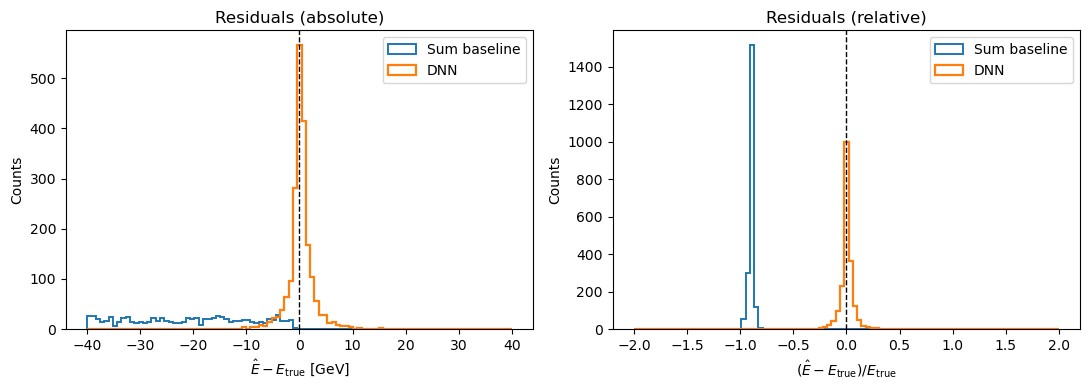

In [9]:
res_dnn  = y_pred - y_true
res_base = y_base - y_true
rel_res_dnn  = res_dnn / np.clip(y_true, 1e-12, None)
rel_res_base = res_base / np.clip(y_true, 1e-12, None)

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
bins = np.linspace(-40, 40, 100)
ax[0].hist(res_base, bins=bins, histtype="step", lw=1.4, label="Sum baseline")
ax[0].hist(res_dnn,  bins=bins, histtype="step", lw=1.6, label="DNN")
ax[0].axvline(0, color='black', ls='--', lw=1)
ax[0].set_xlabel(r"$\hat{E} - E_{\mathrm{true}}$ [GeV]")
ax[0].set_ylabel("Counts")
ax[0].legend(); ax[0].set_title("Residuals (absolute)")

bins_rel = np.linspace(-2, 2, 100)
ax[1].hist(rel_res_base, bins=bins_rel, histtype="step", lw=1.4, label="Sum baseline")
ax[1].hist(rel_res_dnn,  bins=bins_rel, histtype="step", lw=1.6, label="DNN")
ax[1].axvline(0, color='black', ls='--', lw=1)
ax[1].set_xlabel(r"$(\hat{E} - E_{\mathrm{true}})/E_{\mathrm{true}}$"); ax[1].set_ylabel("Counts")
ax[1].legend(); ax[1].set_title("Residuals (relative)")

plt.tight_layout(); plt.show()
